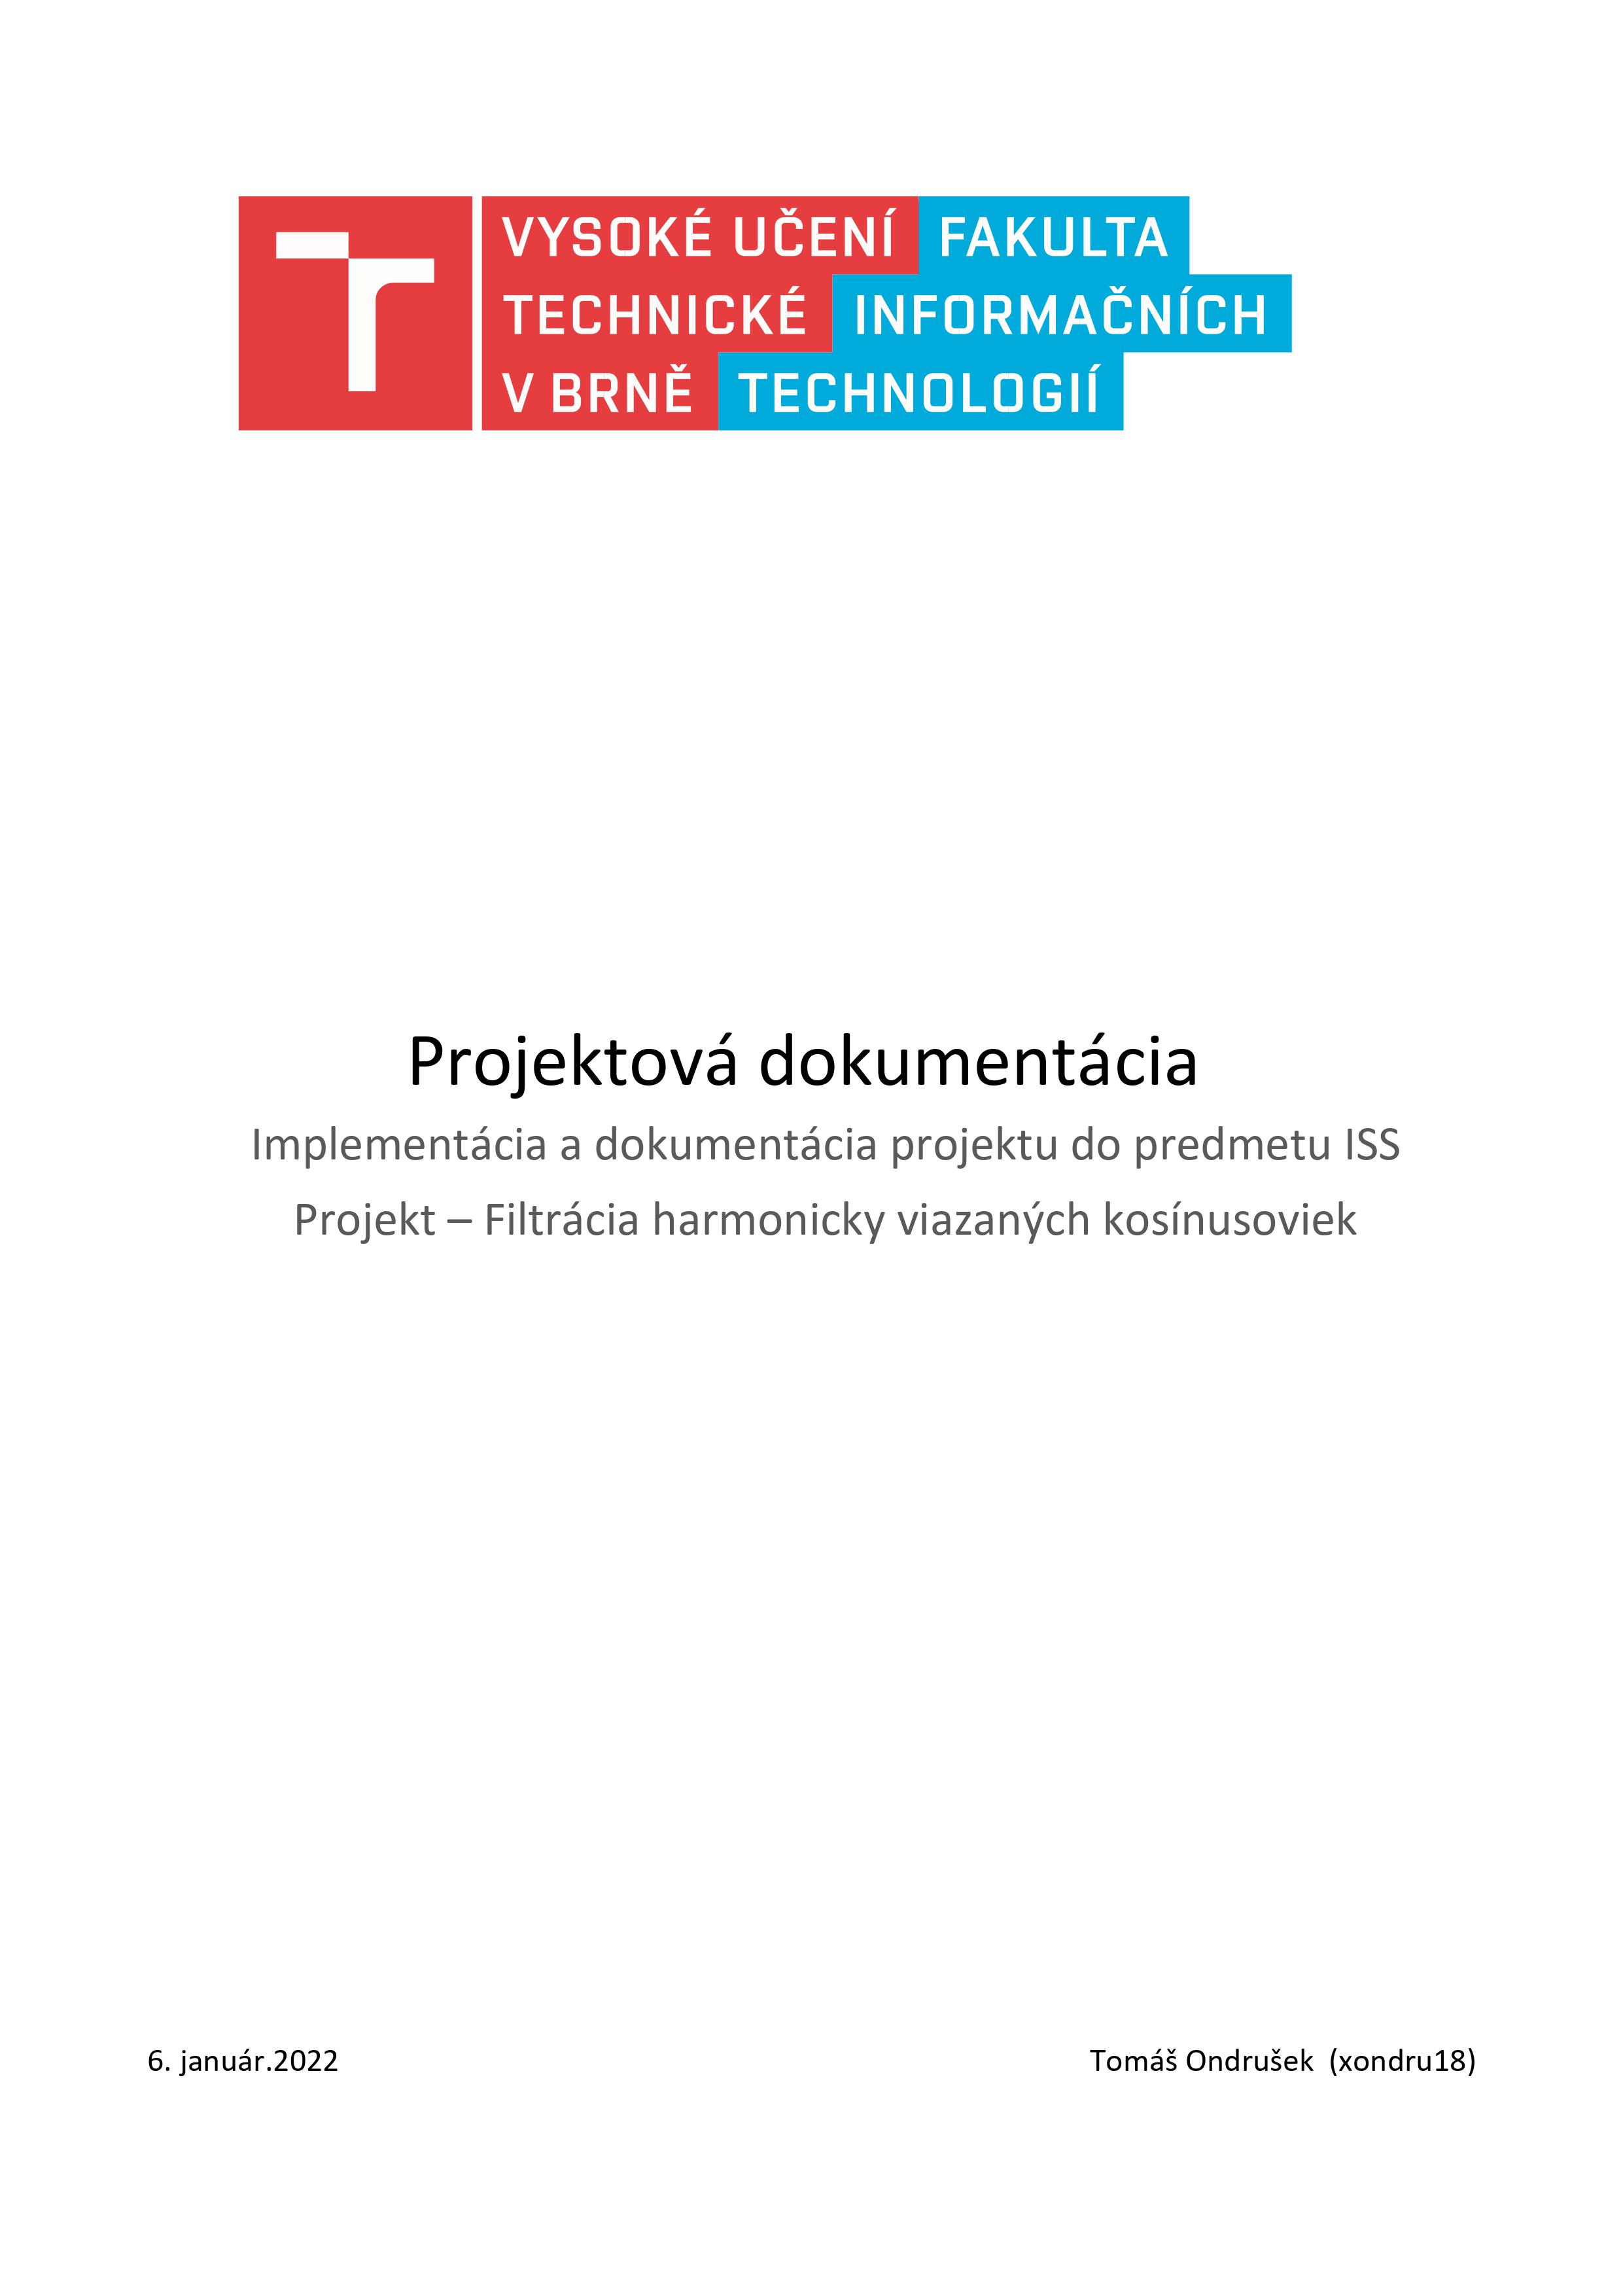

# ISS/VSG Projekt 2021/22

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import math
from numpy.core.numeric import isclose
from scipy.signal import spectrogram, lfilter, freqz, find_peaks, butter
from scipy.io import wavfile

# Načítanie základného signálu
Zo vstupného súboru 'xondru18.wav' načítavam audio nahrávku. <br>
Do premennej fs je uložená vzorkovacia frekvencia, v mojom prípade sa jedná o 16kHz.<br>
Obsah audio nahrávky je uložený do premennej data.
<br>
Čas zistím pomocou nasledujúceho vzorca:
\begin{equation*}
čas = \frac{počet \: vzorkov}{vzorkovacia \: frekvencia}
\end{equation*}

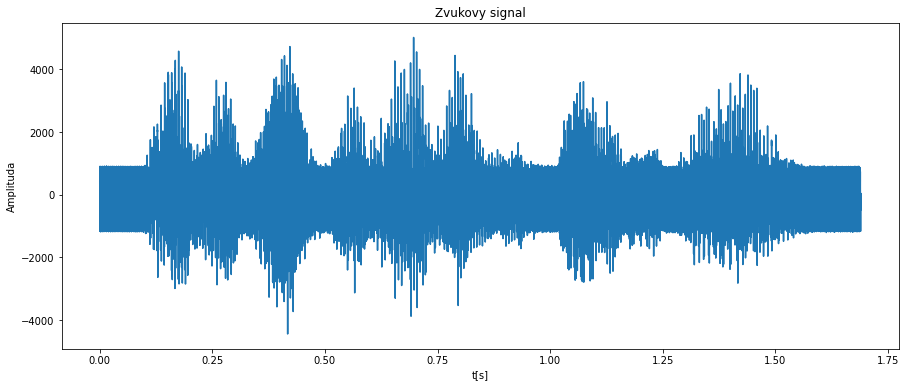

In [2]:
fs, data = wavfile.read("xondru18.wav")
t = np.arange(data.size) / fs
plt.figure(figsize=(15, 6))
plt.plot(t, data)
plt.xlabel("t[s]")
plt.ylabel("Amplituda")
plt.title("Zvukovy signal")
IPython.display.display(IPython.display.Audio(data, rate=fs))

Minimalna hodnota : -4439
Maximalna hodnota : 5015
Dlzka nahravky(vo vzorkoch) : 27034
Dlzka nahravky(v sekundach) : 1.689625 s
Vzorkovacia frekvencia : 16000 Hz


Text(0.5, 1.0, 'Normalizovany zvukovy signal')

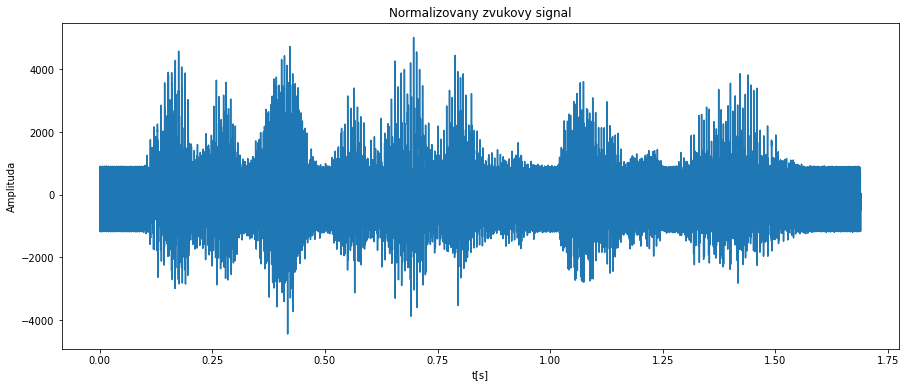

In [3]:
print("Minimalna hodnota :", data.min())
print("Maximalna hodnota :", data.max())
print("Dlzka nahravky(vo vzorkoch) :", len(data))
print("Dlzka nahravky(v sekundach) :", len(data) / fs, "s")
print("Vzorkovacia frekvencia :", fs, "Hz")
plt.figure(figsize=(15, 6))
plt.plot(t, data)
plt.xlabel("t[s]")
plt.ylabel("Amplituda")
plt.title("Normalizovany zvukovy signal")

# Odstránenie jednosmernej zložky
Jednosmernú zložku odstránim odčítaním strednej hodnoty pre každú vzorku signálu

In [4]:
mean = np.mean(data)
for n in range(0, data.size):
    data[n] = data[n] - mean

# Normalizácia
Signál je potreba pred ďalším krokom normalizovať do dynamického rozsahu -1 až 1. <br>
Signál normalizujem pomocou vzorca:
\begin{equation*}
data = \frac{data}{max(\;data.max\;,\;abs(data.min)\;)}
\end{equation*}

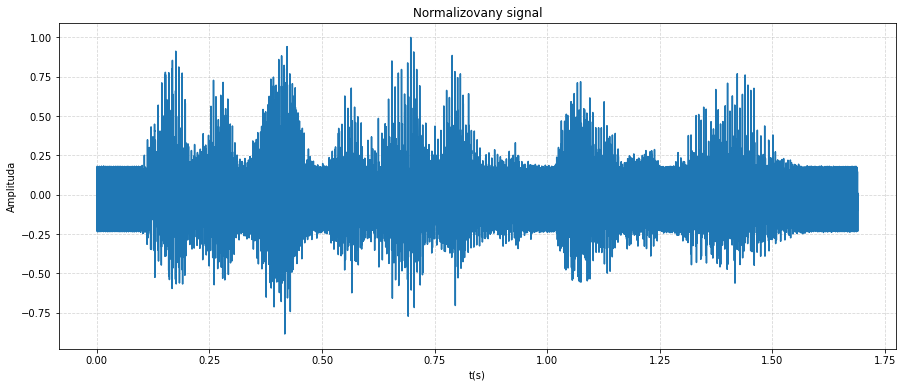

In [5]:
data = data / max(data.max(), -data.min())
refdata = data
plt.figure(figsize=(15, 6))
plt.grid(alpha=0.5, linestyle='--')
plt.title("Normalizovany signal")
plt.xlabel("t(s)")
plt.ylabel("Amplituda")
plt.plot(t, data)

# Rámcovanie
Keďže celkový signál má dĺžku 27034 vzorkov budem na spracovanie potrebovať rámce, ktoré majú byť dlhé 1024 vzorkov a majú mať prekrytie 512 vzorkov.<br>
Počet rámcov viem zistiť zo vzorca:
\begin{equation*}
Počet\;rámcov = 1+\frac{len(data)-len(ramec)}{len(prekrytie)}
\end{equation*}


Text(0, 0.5, 'Amplituda')

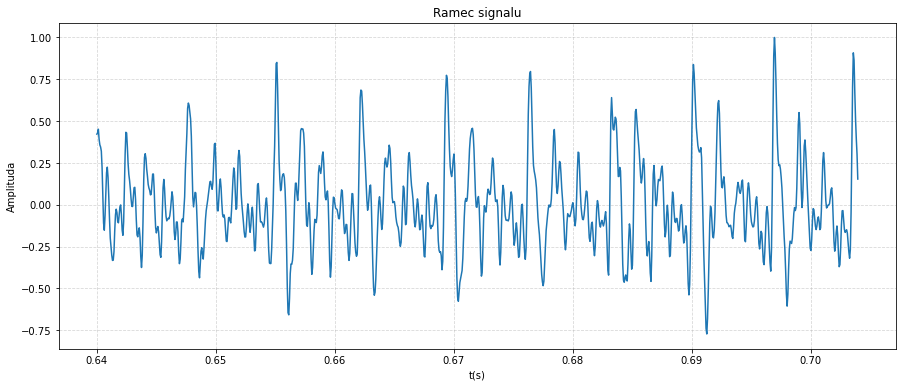

In [6]:
n = 1024  # velkost ramca
m = 512  # dlzka prekrytia
array = [data[i : i + n] for i in range(0, len(data), n - m)]
index = 20  # index matice na vykreslenie
plt.figure(figsize=(15, 6))
plt.grid(alpha=0.5, linestyle='--')
plt.plot(np.arange(index * 512, index * 512 + 1024) / fs, array[index])
plt.title("Ramec signalu")
plt.xlabel("t(s)")
plt.ylabel("Amplituda")

# DFT
## Implementácia vlastnej Diskrétnej Fourierovej Transformácie
Pomocou vlastnej implementácie DFT vykreslím frekvencie z rámca 20.

In [7]:
def dft(array):
#     array = np.append(array, np.zeros(1024 - len(array)))
#     arr = []
#     for i in range(len(array)):
#         coef = 0
#         for j in range(len(array)):
#             coef += array[j] * np.exp(-2j * np.pi * i * j * (1 / len(array)))
#         # ---------------------------------------------------------------zapisujem abs
#         arr.append(coef)
#     return arr
    N = len(array)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)

    X = np.dot(e, array)

    return X

Text(0, 0.5, 'Amplituda')

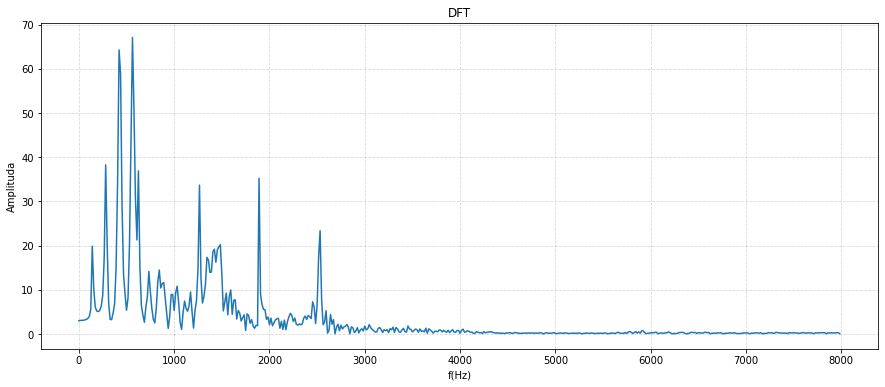

In [8]:
index = 20
after_dft = dft(array[index])
y = np.arange(0, 1024 / 2) * (fs / 2048 * 2)  # pre 512 vzorkov rozsah od 0Hz do 8kHz
plt.figure(figsize=(15, 6))
plt.grid(alpha=0.5, linestyle='--')
plt.plot(y, np.abs(after_dft[:512]))
plt.title("DFT")
plt.xlabel("f(Hz)")
plt.ylabel("Amplituda")

# Kontrola DFT
Pre kontrolu správnosti mojej DFT si vykreslím indentický rámec pomocou knižnicovej funkcie **np.fft.fft()**<br>
Tie teraz porovnám funkciou **np.allclose()**, ktorá vráti *true* ak sú si podobné a *false* ak sa nepodobajú.<br>

In [9]:
correctDFT = np.fft.fft(array[index])
if np.allclose(after_dft, correctDFT):
    print("DFTs match")
else:
    print("Something is wrong")

DFTs match


# Spektogram
Pre generovanie vlastného spektogramu som postupne cez každý rámec robil naslednovné veci:<br>
- ***Predspracovanie*** aktuálneho rámca obsahom tak, aby prázdne polia boli vyplnené nulami
- ***DFT*** aktuálneho rámca
- ***Odseknutie*** polovice rámca, keďže po DFT je rámec symetrický a ja potrebujem iba 1/2
- ***P[k] = 10 log10 |X[k]|^2*** na upravenie hodnôt aktuálneho rámca
- ***Uloženie*** výsledného rámca do poľa

In [10]:
frames = array
spectrum = []

for i in range(53): # jednotlivé rámce
    frames[i] = np.pad(frames[i], (0, 1024 - len(frames[i])), 'constant')
    dftted = np.fft.fft(frames[i])
    spectrum.append(10 * np.log10(np.abs(dftted[:512])**2))

Pre korektné vyzobrazenie dát je potreba otočiť výsledné dáta o 90° pomocou funkcie **np.rot90()**

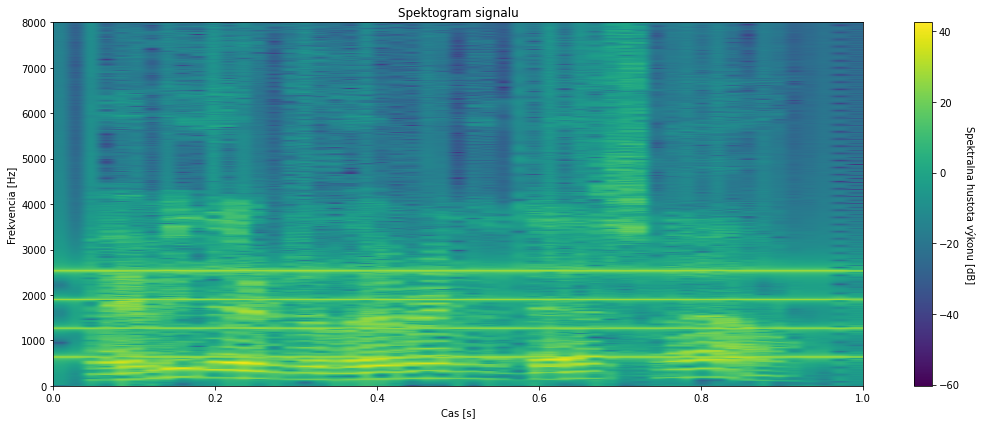

In [11]:
plt.figure(figsize=(15,6))
plt.imshow(np.rot90(spectrum), extent=[0, 1, 0, 8000], aspect='auto')
plt.gca().set_title('Spektogram signalu')
plt.gca().set_xlabel('Cas [s]')
plt.gca().set_ylabel('Frekvencia [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralna hustota výkonu [dB]', rotation=270, labelpad=15)
 
plt.tight_layout()

# Zistenie rušivých frekvencií
Rušivé frekvencie získavam pomocou funkcie **find_peaks()**, ktorá hľadá vrcholy cez celý rámec.<br>
*Height=1* hovorí, že funkcia bude vracať hodnoty, ktoré sú vačšie ako 1.<br>
Aby som vedel priradiť vrcholu frekvenciu, prepočítam vrcholy pomocou vzorcu:
    \begin{equation*}
Peak = Peak*\frac{fs}{1024}
\end{equation*}
Ďalej tímto vrcholom odstránim desatinnú časť a následne ich vypíšem.

In [12]:
dftSpctr = np.fft.fft(array[1])
after_dft_abs = np.abs(dftSpctr)
peaks, _ = find_peaks(after_dft_abs[: len(after_dft) // 2], height=1)
peak_vals = np.abs(dftSpctr[peaks])
peaks = peaks * (fs / 1024)
peaks = [np.floor(float(x)) for x in peaks]
print("Rusive frekvencie : ", peaks)

Rusive frekvencie :  [625.0, 1265.0, 1890.0, 2531.0]


# Kontrola zistených rušivých frekvencií
Porovnávam, či sú rušivé frekvencie sú harmonicky združené (sú násobnky prvej frekvencie).<br>
Ak je frekvencia harmonicky združená, vypisujem že je OK

In [13]:
peak = peaks[0]
before_peak = peaks[0]
diff = 15
for i in peaks:
    if math.isclose(peak, i, abs_tol=diff):
        print("Peak", i, "is OK")
    else:
        print("Peak", i, "is NOT OK")
    peak += before_peak
    diff += 15

Peak 625.0 is OK
Peak 1265.0 is OK
Peak 1890.0 is OK
Peak 2531.0 is OK


# Generovanie signálu
Pre kontrolu rušivého signálu posluchom si potrebujem vygenerovať signál zo štyroch rušivých frekvencií, tie vygenerujem tak, že pre každý vzorok signálu vypočítam súčet štyroch kosínusoviek, ktoré následne zapíšem do výsledného signálu. 

Text(0, 0.5, 'Amplituda')

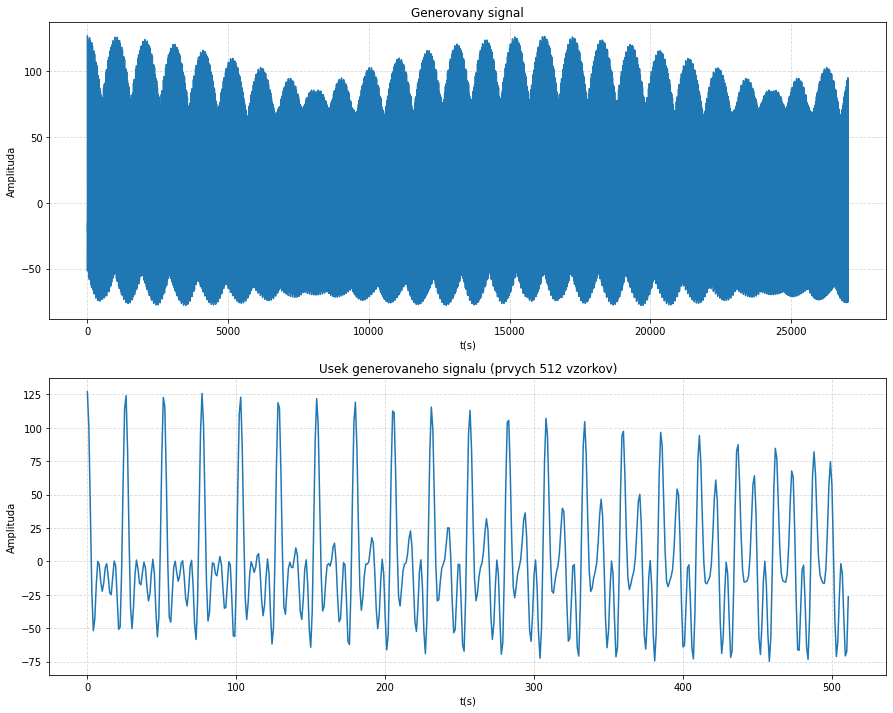

In [14]:
constant = 5/3
time = np.arange(0, len(data), 1)
arr = []
for i in range(0, len(time)):
    item = 0
    for y in range(0, 4):
        item += peak_vals[y] * np.cos(2 * np.pi * constant*i / len(time) * peaks[y])
    arr.append(item)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
ax[0].grid(alpha=0.5, linestyle='--')
ax[1].grid(alpha=0.5, linestyle='--')
ax[0].plot(time, arr)
ax[0].set_title("Generovany signal")
ax[0].set_xlabel("t(s)")
ax[0].set_ylabel("Amplituda")
ax[1].plot(time[:512], arr[:512])
ax[1].set_title("Usek generovaneho signalu (prvych 512 vzorkov)")
ax[1].set_xlabel("t(s)")
ax[1].set_ylabel("Amplituda")

# DFT vygenerovaneho signálu
Pre kontrolu vygenerovaného signálu si ho nechám zobraziť cez DFT, aby som videl že sa v ňom nachádzajú len chcené frekvencie.<br> Vizuálne porovnám s rámcom v ktorom som hľadal rušivé frekvencie.

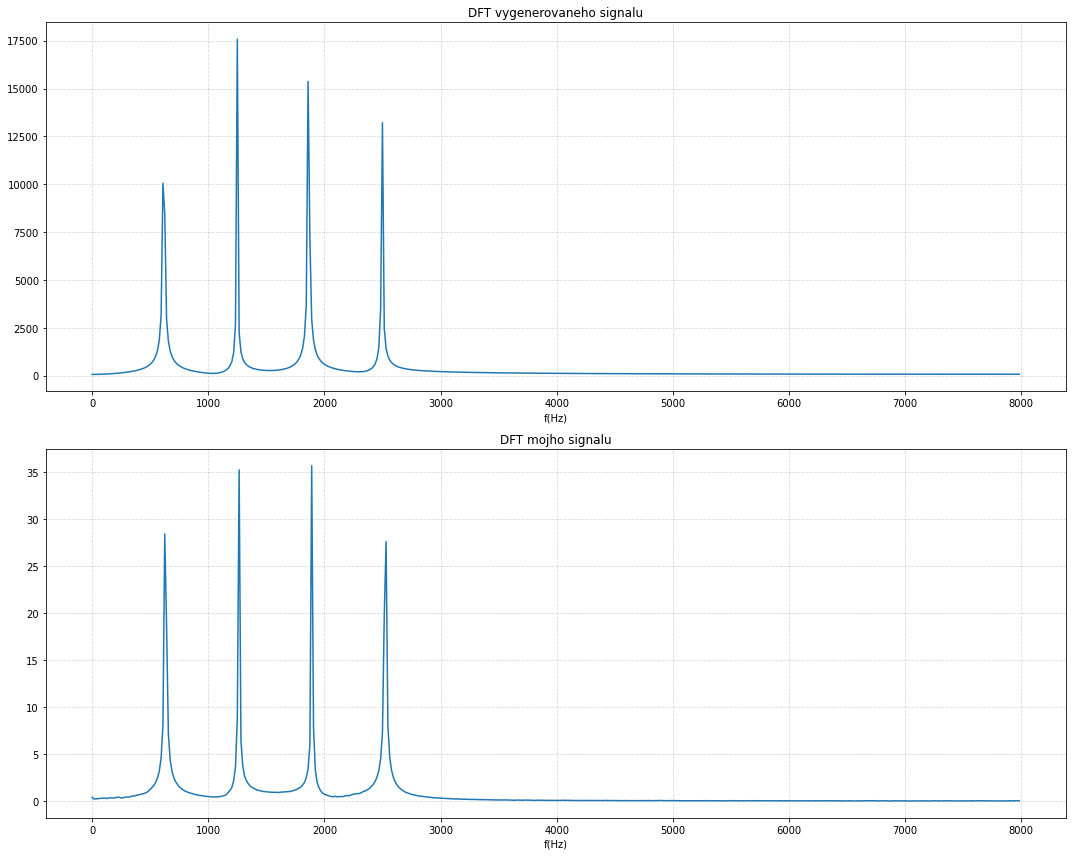

In [15]:
correctDFT = np.fft.fft(arr[:1024])
_, ax = plt.subplots(2,1,figsize=(15, 12))
y = np.arange(0, 1024 / 2) * (fs / 2048 * 2)  # pre 512 vzorkov rozsah od 0Hz do 8kHz
ax[0].plot(y, np.abs(correctDFT[:512]))
ax[0].set_xlabel('f(Hz)')
ax[0].set_title('DFT vygenerovaneho signalu')
ax[0].grid(alpha=0.5, linestyle='--')
correctDFT = np.fft.fft(array[1])
ax[1].plot(y, np.abs(correctDFT[:512]))
ax[1].set_xlabel('f(Hz)')
ax[1].set_title('DFT mojho signalu')
ax[1].grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# Spektogram vygenerovaného signálu
Takisto ako DFT tak si vygenerovaný signál môžem skontrolovať aj cez spektogram, v ktorom vidím, že moje rušivé frekvencie svietia výrazne žltou farbou a vidím, že ich frekvencie sa rovnajú mojím rušivím.

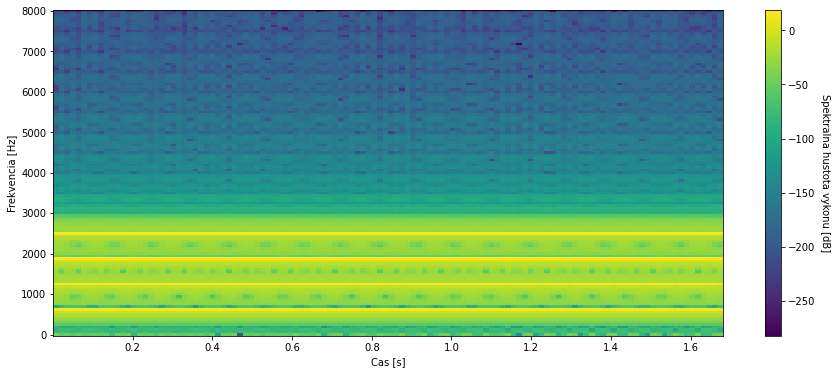

In [16]:
arr = np.asarray(arr, dtype=np.float64)
f, t, sgr = spectrogram(arr, fs)
sgr_log = 10 * np.log10(abs(sgr + 1e-20) ** 2)
plt.figure(figsize=(15, 6))
plt.pcolormesh(t, f, sgr_log)
plt.gca().set_xlabel("Cas [s]")
plt.gca().set_ylabel("Frekvencia [Hz]")
cbar = plt.colorbar()
cbar.set_label("Spektralna hustota vykonu [dB]", rotation=270, labelpad=15)

### Pre vypočutie signálu si signál nechám vygenerovať ako audio

In [17]:
IPython.display.display(IPython.display.Audio(arr, rate=fs))

# Uloženie signálu

In [18]:
samplerate = fs
wavfile.write("audio/cos4.wav", samplerate, arr.astype(np.int16))

# Filtrovanie signálu
Na filtrovanie signálu si potrebujem navrhnúť sadu filtrov, ktoré budú vedieť potláčať tieto frekvencie.<br>
Vybral som si metódu 3. **návrh 4 pásmových zádrží**.<br>
Tieto zádrže budem generovať funkciou **butter()**<br>
Fukcia je volaná s nasledujúcimi parametrami:<br>
- ***Rád*** som nastavil na tretí, lebo som sa rozhodol, že ním vygenerované filtre vyzerali najlepšie.<br>
- ***Medzné frekvencie*** tie sú zapísané nasledovne \[ peaks(i) - 50 , peaks(i) + 50 \].<br>
- ***Typ filtra*** ten som nastavil na 'bandstop', aby filter vyzeral približne takto ''''''''\\/'''''''.<br><br>
Nasledovne týmito filtrami vyfiltrujem signál.<br>
Pre vizualizáciu fitrov ich ukážem na grafe.

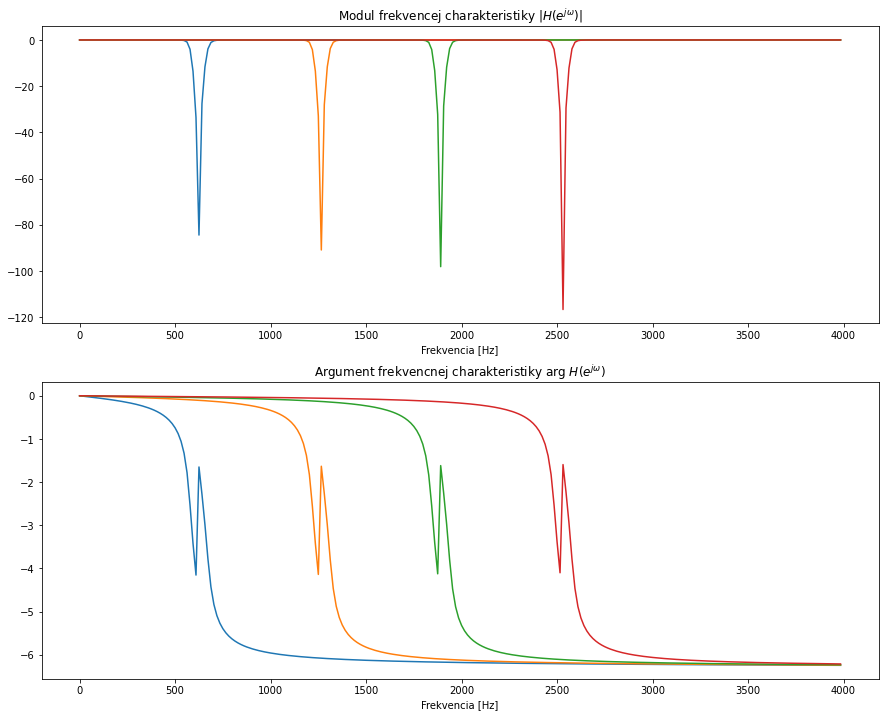

In [19]:
order = 3
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
offset = 50 # sirka 50Hz z kazdej strany
for i in peaks:
    lowcut = i - offset
    highcut = i + offset
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="bandstop")
    data = lfilter(b, a, data)
    freq, h = freqz(b, a, fs=fs)
    ax[0].plot(freq[:256], 20 * np.log10(abs(h[:256])))
    ax[0].set_title('Modul frekvencej charakteristiky $|H(e^{j\omega})|$')
    ax[0].set_xlabel('Frekvencia [Hz]')
    ax[1].plot(freq[:256], np.unwrap(np.angle(h[:256])))
    ax[1].set_title('Argument frekvencnej charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')
    ax[1].set_xlabel('Frekvencia [Hz]')
    



# ODDELENE
# order = 3
# offset = 50 # sirka 50Hz z kazdej strany
# for i in peaks:
#     lowcut = i - offset
#     highcut = i + offset
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype="bandstop")
#     data = lfilter(b, a, data)
#     freq, h = freqz(b, a, fs=fs)
   
#     _, ax = plt.subplots(1, 2, figsize=(15,6))

#     ax[0].plot(freq / 2 / np.pi * fs, np.abs(h))
#     ax[0].set_xlabel('Frekvencia [Hz]')
#     ax[0].set_title('Modul frekvencej charakteristiky $|H(e^{j\omega})|$')
#     ax[0].grid()    
#     ax[1].plot(freq / 2 / np.pi * fs, np.angle(h))
#     ax[1].set_xlabel('Frekvencia [Hz]')
#     ax[1].set_title('Argument frekvencnej charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')
#     ax[1].grid()
#     for ax1 in ax:
#         ax1.grid(alpha=0.5, linestyle='--')

#     plt.tight_layout()

Vyfiltrovaný signál si nechám vypísať.<br>
Je vidno, že signál pripadá byť "čistejší".

Text(0.5, 1.0, 'Filtrovany zvukovy signal prirovnany ku povodnemu')

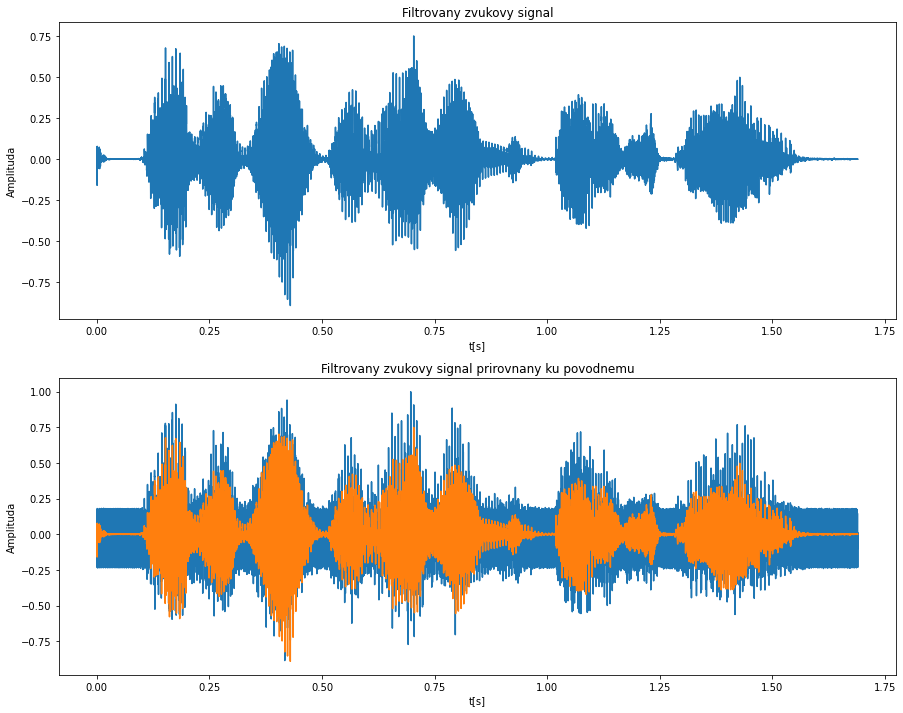

In [20]:
_, ax = plt.subplots(2,1,figsize=(15, 12))
ax[0].plot(np.arange(0, 27034) / fs , data)
ax[0].set_xlabel("t[s]")
ax[0].set_ylabel("Amplituda")
ax[0].set_title("Filtrovany zvukovy signal")
ax[1].plot(np.arange(0, 27034) / fs , refdata)
ax[1].plot(np.arange(0, 27034) / fs , data)
ax[1].set_xlabel("t[s]")
ax[1].set_ylabel("Amplituda")
ax[1].set_title("Filtrovany zvukovy signal prirovnany ku povodnemu")

# Nuly a Póly
Vypočítam nulové body a póly mojich navrhnutých filtrov pomocou funkcie **butter s parametrom output='zpk'**, ktorý vracia nuly a póly.<br>Tie zobrazujem je v komplexnej rovine.

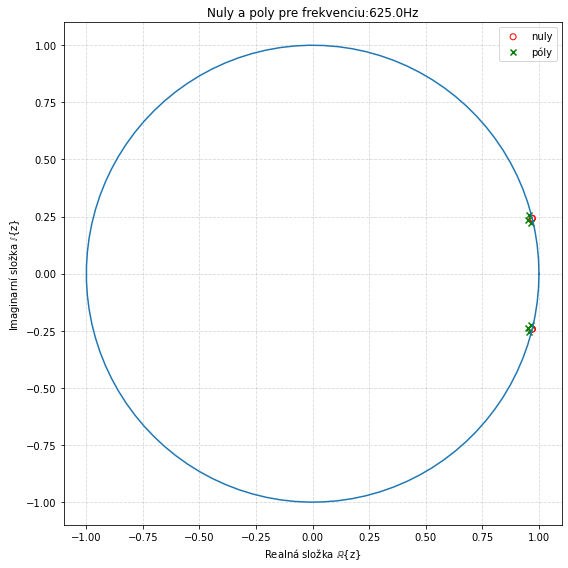

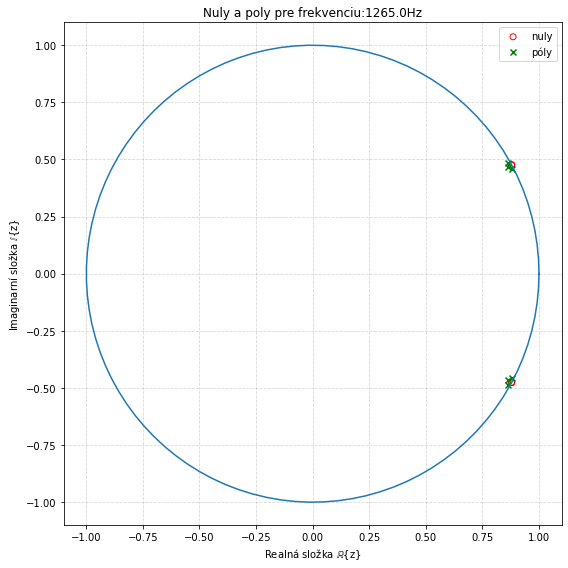

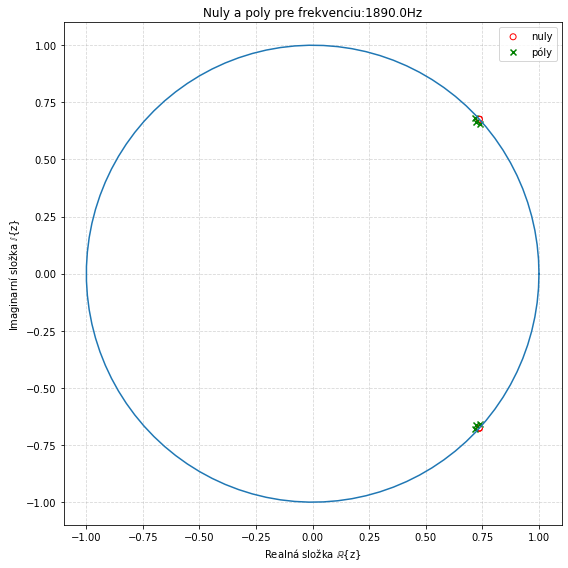

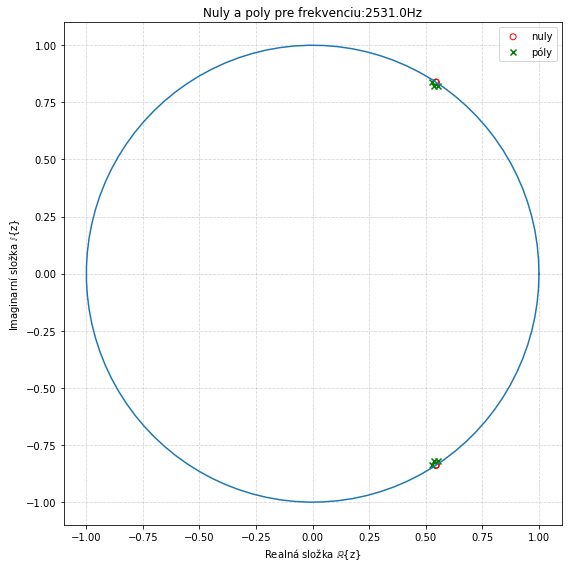

In [21]:
order = 3
pointer = 1
offset = 50 # sirka 50Hz z kazdej strany
for i in peaks:
    lowcut = i - offset
    highcut = i + offset
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    z,p,k = butter(order, [low, high], btype="bandstop", output='zpk')
    plt.figure(figsize=(8, 8))
    ang = np.linspace(0, 2*np.pi,100)
    plt.plot(np.cos(ang), np.sin(ang))
    plt.title("Nuly a poly pre frekvenciu:"+str(i)+"Hz")
    plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')
    plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
    plt.grid(alpha=0.5, linestyle='--')
    plt.legend(loc='upper right')
    plt.tight_layout()
    pointer += 1

# Frekvenčná charakteristika
Pre zistenie frekvenčnej charakteristiky filtra som vytvoril signál dlhý 100 vzorkov ktorý je nulový, okrem prvého vzorku, ktorý je 1. Cez tento signál preženiem filter a sledujem, čo sa zo signálom bude diať.

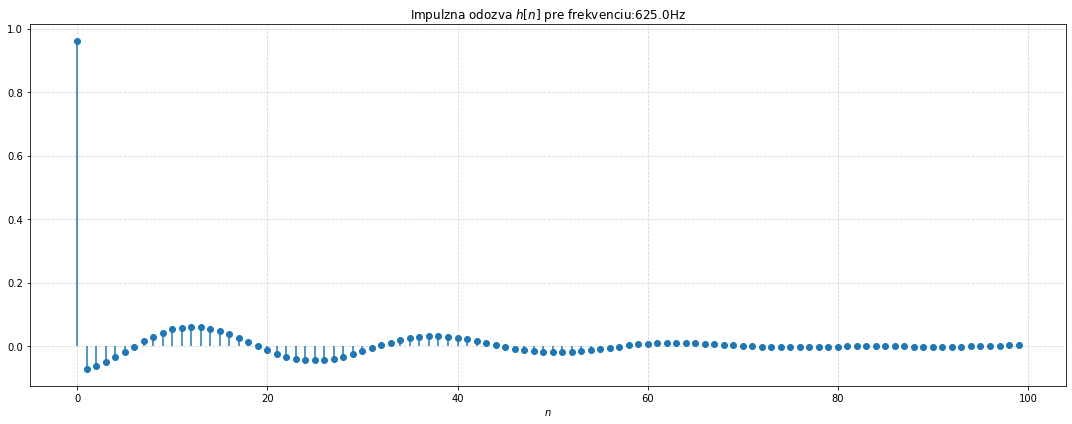

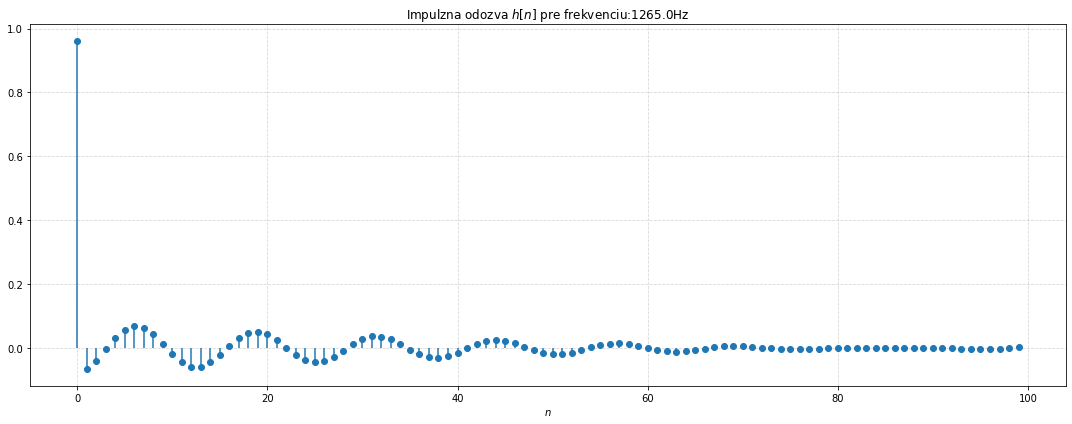

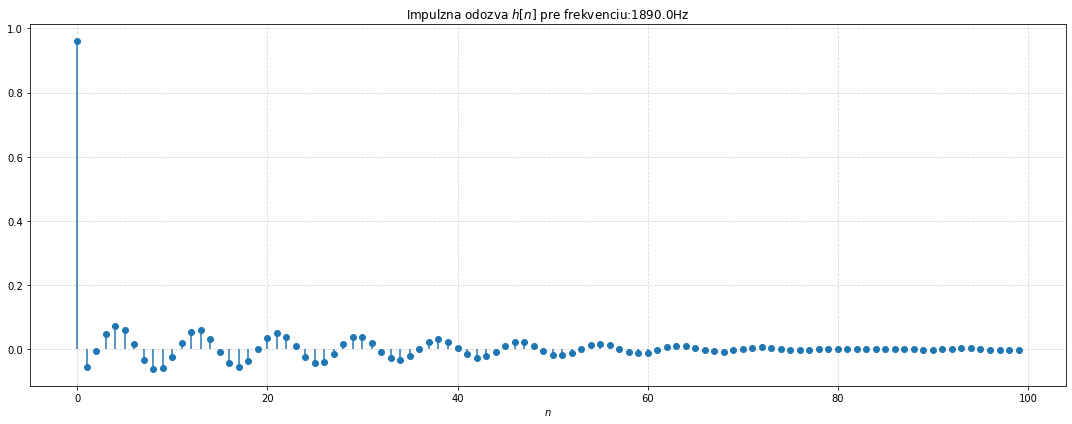

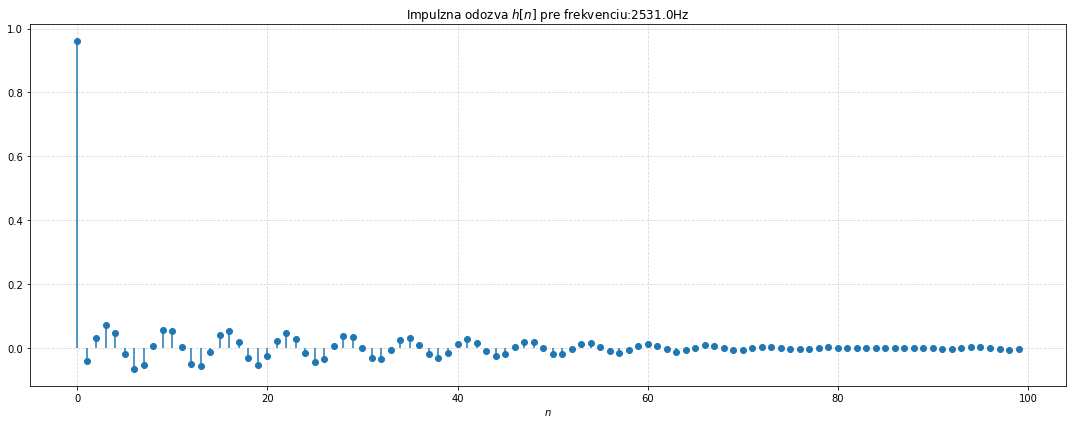

In [22]:
order = 3
offset = 50 # sirka 50Hz z kazdej strany
for i in peaks:
    lowcut = i - offset
    highcut = i + offset
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="bandstop")
    N_imp = 100 # 100 vzorkov
    imp = [1, *np.zeros(N_imp-1)] # inicializacia vzorkov
    h = lfilter(b, a, imp) # filtracia
    plt.figure(figsize=(15, 6))
    plt.stem(np.arange(N_imp), h, basefmt=' ')
    plt.gca().set_xlabel('$n$')
    plt.gca().set_title('Impulzna odozva $h[n]$ pre frekvenciu:'+str(i)+"Hz")
    plt.grid(alpha=0.5, linestyle='--')
    plt.tight_layout()

# Uloženie výsledného signálu
Výsledný vyfiltrovaný signál ukladám ako float64.

In [23]:
samplerate = fs
data = np.asarray(data, dtype=np.float64)
wavfile.write("audio/clean_bandstop.wav", samplerate, data)
IPython.display.display(IPython.display.Audio(data, rate=fs))

# Spektogram výsledného signálu
Pre vygenerovaný signál si nechám vygenerovať spektogram, na ktorom vidno, že horizontálne čiary zo signálu zmyzli.<br>Je ale vidno, že filter nedokáže perfektne zpracovať prvých pár milisekúnd a že filtrovaná nahrávka je na daných rušivých frekvenciaách čiastočne zkreslená. 

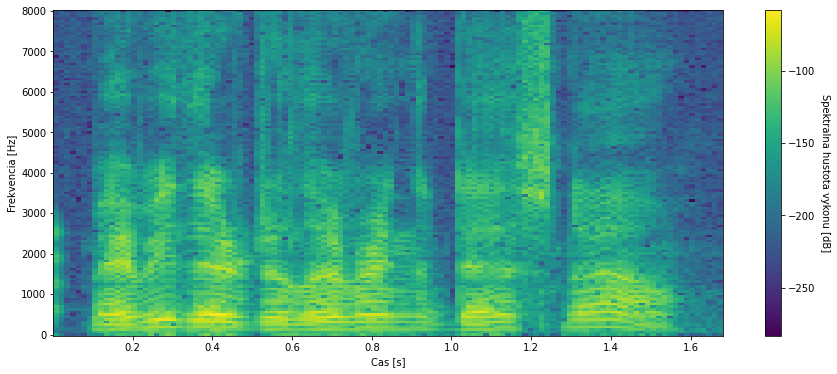

In [24]:
f, t, sgr = spectrogram(data, fs)
sgr_log = 10 * np.log10(abs(sgr + 1e-20) ** 2)
plt.figure(figsize=(15, 6))
plt.pcolormesh(t, f, sgr_log)
plt.gca().set_xlabel("Cas [s]")
plt.gca().set_ylabel("Frekvencia [Hz]")
cbar = plt.colorbar()
cbar.set_label("Spektralna hustota vykonu [dB]", rotation=270, labelpad=15)